#### Foundations of Machine Learning Aug-Nov 2024
##### Sakshi Badole CS24MTECH11008
Question 5: __Random Forests__ for Spam detection 

#### Import Statements

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from math import sqrt, ceil
import time

#### Read data into python dataframe

In [3]:
data = pd.read_csv('https://sites.stat.washington.edu/courses/stat527/s14/homework/hw5/spam.data', delim_whitespace=True, header=None)
y = data.iloc[:,-1].values
X = data.iloc[:, :-1].values

C:\Users\sakshi badole\AppData\Local\Temp\ipykernel_23044\2031304414.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('https://sites.stat.washington.edu/courses/stat527/s14/homework/hw5/spam.data', delim_whitespace=True, header=None)


#### Splitting data into train and test set, with test set = 30% of the data.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Data Standardization

In [5]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Entropy Function

In [6]:
def calculate_entropy(y):
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy

Information Gain Function

In [7]:
def calculate_information_gain(X, y, feature_idx, threshold):
    parent_entropy = calculate_entropy(y)
    
    left_mask = X[:, feature_idx] <= threshold
    right_mask = ~left_mask
    
    left_entropy = calculate_entropy(y[left_mask])
    right_entropy = calculate_entropy(y[right_mask])
    
    n = len(y)
    n_left, n_right = np.sum(left_mask), np.sum(right_mask)
    
    child_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy
    
    return parent_entropy - child_entropy

Accuracy function

In [8]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

#### Decision Tree Implementation

In [9]:

def decision_tree(X_train, y_train, max_depth=None, min_samples_split=2, n_features=None):
    if n_features is None:
        n_features = X_train.shape[1]
    
    if len(y_train) == 0:
        return {'leaf': True, 'class': 0}  
    
    if max_depth == 0 or len(np.unique(y_train)) == 1 or len(y_train) < min_samples_split:
        return {'leaf': True, 'class': np.argmax(np.bincount(y_train))}
    
    feature_indexes = np.random.choice(X_train.shape[1], min(n_features, X_train.shape[1]), replace=False)

    best_feature = None
    best_value = None
    best_gain = -1

    for feature_idx in feature_indexes:
        unique_values = np.unique(X_train[:, feature_idx])
        for limit in unique_values:
            gain = calculate_information_gain(X_train, y_train, feature_idx, limit)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
                best_value = limit
    
    if best_gain == -1:
        return {'leaf': True, 'class': np.argmax(np.bincount(y_train))}
    
    left_mask = X_train[:, best_feature] <= best_value
    right_mask = ~left_mask
    
    left_tree = decision_tree(X_train[left_mask], y_train[left_mask], max_depth-1 if max_depth else None, min_samples_split, n_features)
    right_tree = decision_tree(X_train[right_mask], y_train[right_mask], max_depth-1 if max_depth else None, min_samples_split, n_features)

    return {'leaf': False, 'left': left_tree, 'right': right_tree, 'feature': best_feature, 'limit': best_value}

In [10]:
def predict_tree(tree, X):
    predictions = np.zeros(X.shape[0], dtype=int)
    for i, sample in enumerate(X):
        node = tree
        while not node['leaf']:
            if sample[node['feature']] <= node['limit']:
                node = node['left']
            else:
                node = node['right']
        predictions[i] = node['class']
    return predictions

#### Random Forest Class

In [11]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            bootstrap_indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            tree = decision_tree(X_bootstrap, y_bootstrap, max_depth=self.max_depth, 
                                 min_samples_split=self.min_samples_split, n_features=self.n_features)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([predict_tree(tree, X) for tree in self.trees])
        return np.round(np.mean(tree_preds, axis=0)).astype(int)

    def oob_error(self, X, y):
        n_samples = X.shape[0]
        oob_predictions = np.zeros(n_samples)
        n_predictions = np.zeros(n_samples)

        for tree in self.trees:
            oob_mask = np.random.rand(n_samples) > 1/np.e
            tree_pred = predict_tree(tree, X[oob_mask])
            oob_predictions[oob_mask] += tree_pred
            n_predictions[oob_mask] += 1

        valid_mask = n_predictions > 0
        oob_predictions[valid_mask] /= n_predictions[valid_mask]
        oob_predictions = np.round(oob_predictions).astype(int)

        return 1 - accuracy(y[valid_mask], oob_predictions[valid_mask])

In [12]:
# Custom Random Forest
start_time = time.time()
custom_rf = RandomForest(n_trees=100, max_depth=10, n_features=int(np.sqrt(X_train.shape[1])))
custom_rf.fit(X_train, y_train)
custom_pred = custom_rf.predict(X_test)
custom_accuracy = accuracy(y_test, custom_pred)
time_RF = time.time() - start_time

#### Scikit-learn Random Forest

In [13]:
# Scikit-learn Random Forest
start_time = time.time()
sklearn_rf = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=int(np.sqrt(X_train.shape[1])), random_state=42)
sklearn_rf.fit(X_train, y_train)
sklearn_pred = sklearn_rf.predict(X_test)
sklearn_accuracy = accuracy(y_test, sklearn_pred)
time_sklearn_RF = time.time() - start_time

Accuracies and Running time of Custom Random Forest and Scikit-learn Random Forest

In [14]:
print(f"Custom Random Forest - Accuracy: {custom_accuracy:.4f} and Time taken: {time_RF:.2f} seconds")
print(f"Scikit-learn Random Forest - Accuracy: {sklearn_accuracy:.4f} and Time taken: {time_sklearn_RF:.2f} seconds")


Custom Random Forest - Accuracy: 0.9457 and Time taken: 151.48 seconds
Scikit-learn Random Forest - Accuracy: 0.9457 and Time taken: 0.60 seconds


#### Sensitivity of Random Forest accuracies with respect to different vaues of m

In [15]:
m_values = [int(0.5 * np.sqrt(X_train.shape[1])), int(np.sqrt(X_train.shape[1])), int(2 * np.sqrt(X_train.shape[1]))]
m_accuracies = []
for m in m_values:

    start_time = time.time()
    custom_rf = RandomForest(n_trees=100, max_depth=10, n_features= m )
    custom_rf.fit(X_train, y_train)
    custom_pred = custom_rf.predict(X_test)
    custom_accuracy = accuracy(y_test, custom_pred)
    m_accuracies.append(custom_accuracy)
    time_RF = time.time() - start_time
    print(f"Custom Random Forest - Accuracy: {custom_accuracy:.4f} and Time taken: {time_RF:.2f} seconds for m: {m}")


Custom Random Forest - Accuracy: 0.9356 and Time taken: 68.03 seconds for m: 3
Custom Random Forest - Accuracy: 0.9406 and Time taken: 135.11 seconds for m: 7
Custom Random Forest - Accuracy: 0.9450 and Time taken: 281.87 seconds for m: 15


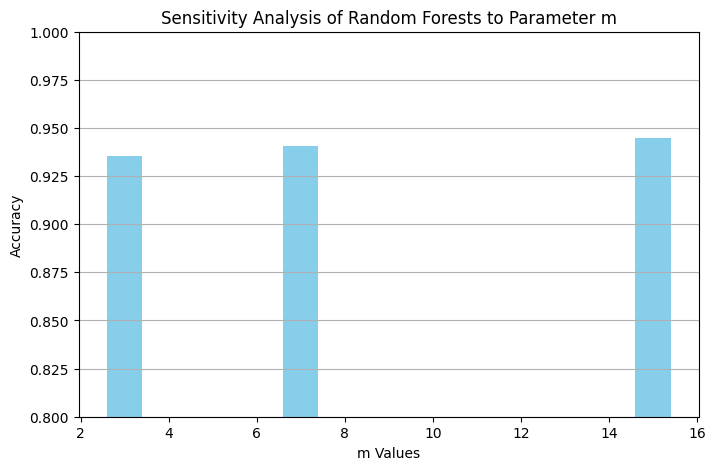

In [16]:
results_df = pd.DataFrame({
    'm value': m_values,
    'Accuracy': m_accuracies
})

plt.figure(figsize=(8, 5))
plt.bar(results_df['m value'], results_df['Accuracy'], color='skyblue')
plt.title('Sensitivity Analysis of Random Forests to Parameter m')
plt.xlabel('m Values')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  
plt.grid(axis='y')
plt.show()

#### Out-of-Bag Error and Test error for different values of M : [0.5*$\sqrt{M}$, $\sqrt{M}$, 2*$\sqrt{M}$ ]

In [17]:
m_values = [int(0.5 * np.sqrt(X_train.shape[1])), int(np.sqrt(X_train.shape[1])), int(2 * np.sqrt(X_train.shape[1]))]
oob_errors = []
test_errors = []

for m in m_values:
    rf = RandomForest(n_trees=100, max_depth=10, n_features=m)
    rf.fit(X_train, y_train)
    oob_errors.append(rf.oob_error(X_train, y_train))
    test_pred = rf.predict(X_test)
    test_errors.append(1 - accuracy(y_test, test_pred))

In [18]:
print(f"Out-Of-Bag error and Test error values for m:{m_values[0]} : {oob_errors[0]:.2f} and {test_errors[0]:.5f}")
print(f"Out-Of-Bag error and Test error values for m:{m_values[1]} : {oob_errors[1]:.2f} and {test_errors[1]:.5f}")
print(f"Out-Of-Bag error and Test error values for m:{m_values[2]} : {oob_errors[2]:.2f} and {test_errors[2]:.5f}")

Out-Of-Bag error and Test error values for m:3 : 0.05 and 0.06951
Out-Of-Bag error and Test error values for m:7 : 0.04 and 0.05793
Out-Of-Bag error and Test error values for m:15 : 0.03 and 0.05648


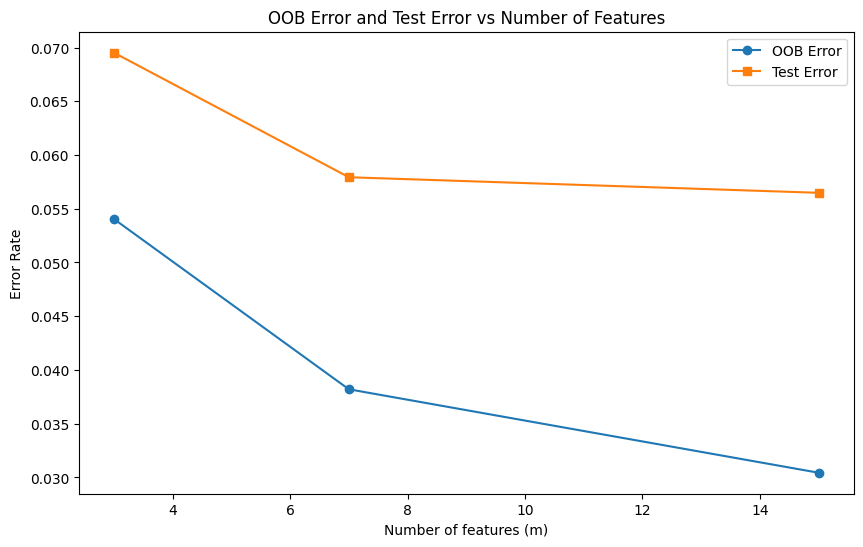

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(m_values, oob_errors, label='OOB Error', marker='o')
plt.plot(m_values, test_errors, label='Test Error', marker='s')
plt.xlabel('Number of features (m)')
plt.ylabel('Error Rate')
plt.title('OOB Error and Test Error vs Number of Features')
plt.legend()
plt.show()